<a href="https://colab.research.google.com/github/Ayllinice/Filin_AI_Labs/blob/main/LAB4AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная № 4
### Филин Илья Александрович
### БИВТ-22-СП-4

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

1.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Sleep_health_and_lifestyle_dataset.csv', sep=',')

In [ ]:
missing_values = data.isnull().sum()
missing_values

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [ ]:
data.fillna({"Sleep Disorder":"No problems"},inplace=True)

In [ ]:
data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,No problems
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No problems
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,No problems
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


2. Определение задачи

Это задача многоклассовой классификации, так как целевая переменная принимает категориальные значения, а не является числовым или непрервным значением.

3. Предобработка данных

Поле Blood Pressure имеет тип данных object. Его значения сильно разнятся, лучше сделать классификацию по давлению у людей.

In [ ]:
def categorize_bp(bp):
    systolic, diastolic = map(int, bp.split('/'))
    if systolic < 120 and diastolic < 80:
        return "Normal"
    elif 120 <= systolic < 130 and diastolic < 80:
        return "Elevated"
    elif 130 <= systolic < 140 or 80 <= diastolic < 90:
        return "Hypertension Stage 1"
    else:
        return "Hypertension Stage 2"

data['BP_Category'] = data['Blood Pressure'].apply(categorize_bp)

In [ ]:
data['Sleep Disorder'] = LabelEncoder().fit_transform(data['Sleep Disorder'])

Разделение X и Y

In [ ]:
X=data.drop(['Sleep Disorder','Person ID','Blood Pressure'], axis=1)

In [ ]:
Y=data['Sleep Disorder']

Разделение данных на train и test. В отношение 80 на 20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=17)

Нормировка численных переменных

In [ ]:
standard_columns=['Age','Heart Rate']
minmax_columns=['Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level','Daily Steps']
X_train_mixed_scaling = X_train.copy()
X_train_mixed_scaling[standard_columns] = StandardScaler().fit_transform(X_train_mixed_scaling[standard_columns])
X_train_mixed_scaling[minmax_columns] = MinMaxScaler().fit_transform(X_train_mixed_scaling[minmax_columns])
X_train=X_train_mixed_scaling.copy()

In [ ]:
standard_columns=['Age','Heart Rate']
minmax_columns=['Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level','Daily Steps']
X_test_mixed_scaling = X_test.copy()
X_test_mixed_scaling[standard_columns] = StandardScaler().fit_transform(X_test_mixed_scaling[standard_columns])
X_test_mixed_scaling[minmax_columns] = MinMaxScaler().fit_transform(X_test_mixed_scaling[minmax_columns])
X_test=X_test_mixed_scaling.copy()

Кодирование категориальных признаков

In [ ]:
X_train['Gender'] = LabelEncoder().fit_transform(X_train['Gender'])
X_test['Gender'] = LabelEncoder().fit_transform(X_test['Gender'])
X_train['Occupation'] = LabelEncoder().fit_transform(X_train['Occupation'])
X_test['Occupation'] = LabelEncoder().fit_transform(X_test['Occupation'])
X_train['BMI Category'] = LabelEncoder().fit_transform(X_train['BMI Category'])
X_test['BMI Category'] = LabelEncoder().fit_transform(X_test['BMI Category'])
X_train['BP_Category'] = LabelEncoder().fit_transform(X_train['BP_Category'])
X_test['BP_Category'] = LabelEncoder().fit_transform(X_test['BP_Category'])

In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 299 entries, 231 to 111
Series name: Sleep Disorder
Non-Null Count  Dtype
--------------  -----
299 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


4. Оформить данные в виде класса Dataset из библиотеки torch (как мы это делали на семинаре), а затем засунуть в Dataloader (тоже делали на семинаре).

In [ ]:
import torch
import torchvision
from torch import nn
import os
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import tqdm
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Lambda

In [ ]:
torch.cuda.is_available()

False

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SleepDs(Dataset):
    def __init__(self, X, Y):# конструктор на вход получает признаки и целевую переменную
        self.X = X.reset_index(drop=True)  #избавляемся от индексов
        self.Y = Y.reset_index(drop=True) #чтобы избежать проблем с несовпадением индексов в выборках.

    def __len__(self):#кол-во пакетов
        return len(self.X)

    def __getitem__(self, idx): #возвращает признаки и целевое значение для индекса
        features = torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)
        target = torch.tensor(self.Y.iloc[idx], dtype=torch.float32)
        return features, target

train_dataset = SleepDs(X_train, y_train)
test_dataset = SleepDs(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_loader), len(test_loader)


(5, 2)

5. Обучение на тестовом множестве.

Очень простую однослойную нейросеть с оптимизатором SGD

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Net1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net1, self).__init__() #инициализация базового класса
        self.fc = nn.Linear(input_size, num_classes) #создаем первый линейный слой

    def forward(self, x):
        return self.fc(x) #возвращает предсказания

# Параметры
num_epochs = 100
learning_rate_1 = 0.001
train_losses_a = []
test_losses_a = []
#Инициализация
model_a = Net1(input_size=X_train.shape[1], num_classes=len(Y.unique()))
criterion_a = nn.CrossEntropyLoss() #функция потерь для Классификации
optimizer_a = optim.SGD(model_a.parameters(), lr=learning_rate_1)


for epoch in range(num_epochs):
    model_a.train()
    running_loss = 0.0
    for batch_features, batch_targets in train_loader:
        optimizer_a.zero_grad() #обнуление градиента
        batch_targets = batch_targets.type(torch.long) #чтобы не ругался приведение типов
        outputs = model_a(batch_features) #предсказания для пакета
        loss = criterion_a(outputs, batch_targets) # вычисление ошибки между predictions и real
        loss.backward() #подсчет градиента
        optimizer_a.step() #обновляет параметры модели
        running_loss += loss.item() #накопление ошибки
    train_loss = running_loss / len(train_loader)
    train_losses_a.append(train_loss)

    model_a.eval() #оценивание модели
    test_running_loss = 0.0

    with torch.no_grad(): #отключаем градиент, меньше расход памяти
        for batch_features, batch_targets in test_loader:
            batch_targets = batch_targets.type(torch.long)
            outputs = model_a(batch_features) #получение предсказаний
            loss = criterion_a(outputs, batch_targets) #вычисление потерь для итерации
            test_running_loss += loss.item() #накопление потерь

    test_loss = test_running_loss / len(test_loader)
    test_losses_a.append(test_loss)


Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором Adam

In [ ]:
class Net2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)# вход--скрытый слой
        self.relu = nn.ReLU() #обнуляет отрицательные для внедрения нелинейности
        self.fc2 = nn.Linear(hidden_size, num_classes)# скрытый слой--выход

    def forward(self, x):#как данные проходят через сеть
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


num_epochs = 100
learning_rate_2 = 0.001
train_losses_b = []
test_losses_b = []
print(X_train.shape[1])
model_b = Net2(input_size=X_train.shape[1], hidden_size=64, num_classes=len(Y.unique()))
criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(model_b.parameters(), lr=learning_rate_2)

for epoch in range(num_epochs):
    model_b.train()
    running_loss = 0.0
    for batch_features, batch_targets in train_loader:
        optimizer_b.zero_grad()
        batch_targets = batch_targets.type(torch.long)
        outputs = model_b(batch_features)
        loss = criterion_b(outputs, batch_targets)
        loss.backward()
        optimizer_b.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses_b.append(train_loss)
    model_b.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_targets = batch_targets.type(torch.long)
            outputs = model_b(batch_features)
            loss = criterion_b(outputs, batch_targets)
            test_running_loss += loss.item()

    test_loss = test_running_loss / len(test_loader)
    test_losses_b.append(test_loss)



11


Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam

In [ ]:
class Net3(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(Net3, self).__init__()
        self.layers = nn.ModuleList()#контейнер хранения слоёв
        self.layers.append(nn.Linear(input_size, hidden_sizes[0])) # 1 скрытый слой
        for i in range(1, len(hidden_sizes)): # Скрытые слои
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
        self.layers.append(nn.Linear(hidden_sizes[-1], num_classes)) # Последний слой
        self.relu = nn.ReLU()#обнуляет отрицательные для внедрения нелинейности

    def forward(self, x):
        for layer in self.layers[:-1]:  # Применяем обнуление отрицательных ко всем слоям кроме последнего
            x = self.relu(layer(x))
        x = self.layers[-1](x)  #последний слой
        return x


num_epochs = 100
learning_rate_3 = 0.001
train_losses_c = []
test_losses_c = []

hidden_sizes_c = [128, 64, 32]
model_c = Net3(input_size=X_train.shape[1], hidden_sizes=hidden_sizes_c, num_classes=len(Y.unique()))
criterion_c = nn.CrossEntropyLoss()
optimizer_c = optim.Adam(model_c.parameters(), lr=learning_rate_3)

for epoch in range(num_epochs):
    model_c.train()
    running_loss = 0.0
    for batch_features, batch_targets in train_loader:
        optimizer_c.zero_grad()
        batch_targets = batch_targets.type(torch.long)
        outputs = model_c(batch_features)
        loss = criterion_c(outputs, batch_targets)
        loss.backward()
        optimizer_c.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses_c.append(train_loss)
    model_c.eval()
    test_running_loss = 0.0

    with torch.no_grad():
        for batch_features, batch_targets in test_loader:
            batch_targets = batch_targets.type(torch.long)
            outputs = model_c(batch_features)
            loss = criterion_c(outputs, batch_targets)
            test_running_loss += loss.item()

    test_loss = test_running_loss / len(test_loader)
    test_losses_c.append(test_loss)

6. Подсчёт loss и построение кривой модели обучения

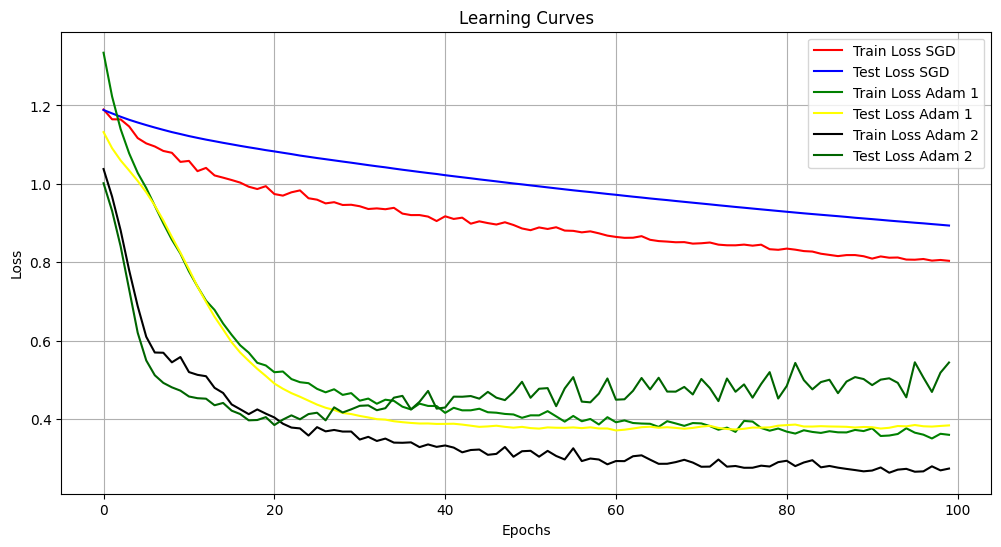

In [ ]:
plt.figure(figsize=(12 ,6 ))
plt.plot(train_losses_a,label='Train Loss SGD', color='red')
plt.plot(test_losses_a,label='Test Loss SGD', color='blue')
plt.plot(train_losses_b,label='Train Loss Adam 1', color='green')
plt.plot(test_losses_b,label='Test Loss Adam 1', color='yellow')
plt.plot(train_losses_c,label='Train Loss Adam 2', color='black')
plt.plot(test_losses_c,label='Test Loss Adam 2', color='darkgreen')

plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

7. Подсчёт метрик

In [ ]:
def calculate_accuracy(model):
    model.eval()  #режим оценки
    with torch.no_grad(): #отключаем градиент, так как идет только оценка
        correct_train = 0
        total_train = 0

        for batch_features, batch_targets in train_loader: #цикл по батчам
            outputs_train = model(batch_features) #предсказывание
            _, predicted_train = torch.max(outputs_train.data, 1) #наиболее вероятное предсказание
            total_train += batch_targets.size(0)
            correct_train += (predicted_train == batch_targets).sum().item()

        accuracy_train = correct_train / total_train

        correct_test = 0
        total_test = 0

        for batch_features_test, batch_targets_test in test_loader:
            outputs_test = model(batch_features_test)
            _, predicted_test = torch.max(outputs_test.data ,1)
            total_test += batch_targets_test.size(0)
            correct_test += (predicted_test == batch_targets_test).sum().item()

        accuracy_test= correct_test / total_test

    return accuracy_train, accuracy_test

accuracy_a_train, accuracy_a_test= calculate_accuracy(model_a)
accuracy_b_train, accuracy_b_test= calculate_accuracy(model_b)
accuracy_c_train, accuracy_c_test= calculate_accuracy(model_c)

print(f'Accuracy Model A - Train: {accuracy_a_train:.2f}, Test: {accuracy_a_test:.2f}')
print(f'Accuracy Model B - Train: {accuracy_b_train:.2f}, Test: {accuracy_b_test:.2f}')
print(f'Accuracy Model C - Train: {accuracy_c_train:.2f}, Test: {accuracy_c_test:.2f}')

Accuracy Model A - Train: 0.77, Test: 0.77
Accuracy Model B - Train: 0.89, Test: 0.91
Accuracy Model C - Train: 0.93, Test: 0.93


8. Валидация

1. Модель C справилась лучше всех, показав высокий результат и стабильность на test и train.

2. Так как есть разрыв между train test, модель B имеет перееобучение.

3. Нет не имеет.

4. Изменить гиперпараметры, увеличить сложность модели.